In [1]:
# Simple RNN-LSTM regression
# 2017-03-16 jkang
# Python3.5
# Tensorflow1.0.1
#
# input: sinewaves (varying frequency, amplitude and duration)
# output: one-sample shifted inputs
#
# no batch mode (online training)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input, Ouput dataset
n_examples = 100
srate = 200  # Hz
sin_in = {}
sin_out = {}
for i in range(n_examples):
    freq = np.random.random(1) * 10 + 1  # 1 <= freq < 11 Hz
    amplitude = np.random.random(1) * 10
    duration = np.random.random(1) * 5 + 5  # sample from 5 ~ 10 sec
    t = np.linspace(0, duration, duration * srate + 1)
    sin = np.sin(2 * np.pi * freq * t) * amplitude
    key = 's' + str(i + 1)
    sin_in[key] = sin[:-1]
    sin_out[key] = sin[1:]  # one sample shifting

/home/zzandore/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [3]:
# Hyper-Parameters
learning_rate = 0.001
max_iter = 20

# Network Parameters
n_input_dim = 1
n_input_len = len(sin_in)
n_output_len = len(sin_out)
n_hidden = 100
n_output_dim = 1

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x = tf.placeholder(tf.float32, [1, None, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y = tf.placeholder(tf.float32, [1, None, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output_dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output_dim]))
}

In [4]:
def RNN(inputs, weights, biases):
    # Reshape to (time_step) x (batch_size) x (input_dimension)
    inputs = tf.transpose(inputs, [1, 0, 2])
    # Reshape to (time_step)*(batch_size) x (input_dimension)
    inputs = tf.reshape(inputs, [-1, n_input_dim])
    # Split to get a list of time_step tensors of shape (batch_size, input_dimension)
    # final 'inputs' is a list of n_input_len elements (=number of frames)
    inputs = tf.split(
        value=inputs, num_or_size_splits=n_input_len, axis=0)

    lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.squared_difference(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [5]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= max_iter:
        loss = 0
        for i in range(n_examples):
            key = 's' + str(i + 1)
            train_x = sin_in[key].reshape((1, len(sin_in[key]), n_input_dim))
            train_y = sin_out[key].reshape(
                (1, len(sin_out[key]), n_output_dim))
            c, _ = sess.run([cost, optimizer], feed_dict={
                            x: train_x, y: train_y})
            loss += c
        mean_mse = loss / n_examples

        print('Epoch =', str(step), '/', str(max_iter),
              'Cost = ', '{:.5f}'.format(mean_mse))
        step += 1

Epoch = 1 / 20 Cost =  4.98035
Epoch = 2 / 20 Cost =  0.55509
Epoch = 3 / 20 Cost =  0.19051
Epoch = 4 / 20 Cost =  0.10151
Epoch = 5 / 20 Cost =  0.06873
Epoch = 6 / 20 Cost =  0.05156
Epoch = 7 / 20 Cost =  0.04012
Epoch = 8 / 20 Cost =  0.03081
Epoch = 9 / 20 Cost =  0.02531
Epoch = 10 / 20 Cost =  0.02227
Epoch = 11 / 20 Cost =  0.02160
Epoch = 12 / 20 Cost =  0.02115
Epoch = 13 / 20 Cost =  0.02081
Epoch = 14 / 20 Cost =  0.02054
Epoch = 15 / 20 Cost =  0.02013
Epoch = 16 / 20 Cost =  0.01955
Epoch = 17 / 20 Cost =  0.01891
Epoch = 18 / 20 Cost =  0.01830
Epoch = 19 / 20 Cost =  0.01767
Epoch = 20 / 20 Cost =  0.01707


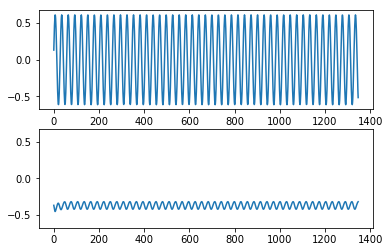

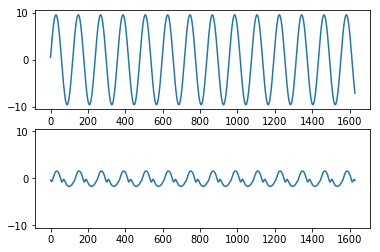

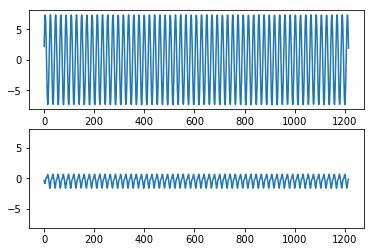

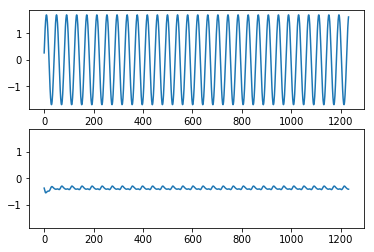

In [17]:
# Test
with tf.Session() as sess:
    sess.run(init)
    for i in np.arange(5)[1:]:
        idx = 's' + str(np.random.permutation(n_examples)[0])
        test_x = sin_in[idx].reshape((1, len(sin_in[idx]), n_input_dim))
        pred_out = sess.run(pred, feed_dict={x: test_x})
        f, axes = plt.subplots(2, sharey=True)
        axes[0].plot(sin_out[idx])
        axes[1].plot(pred_out)
        plt.show()
        #f.savefig('result_' + idx + '.png')